**PREPARATION**

In [ ]:
# This ipynb file can be used to reproduce the whole pipeline of preparing and loading data, and
# to train the desired model

In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm
import sys
import ddpm_ours
import datasets
import os
import trimesh
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

print(f"PyTorch version Installed: {torch.__version__}\nTorchvision version Installed: {torchvision.__version__}\n")
if not torch.__version__.startswith("1.11"):
    print("you are using an another version of PyTorch. We expect PyTorch 1.11.0. You may continue using your version but it"
          " might cause dependency and compatibility issues.")
if not torchvision.__version__.startswith("0.12"):
    print("you are using an another version of torchvision. We expect torchvision 0.12. You can continue with your version but it"
          " might cause dependency and compatibility issues.")

PyTorch version Installed: 2.0.1+cu117
Torchvision version Installed: 0.15.2+cu117

you are using an another version of PyTorch. We expect PyTorch 1.11.0. You may continue using your version but it might cause dependency and compatibility issues.
you are using an another version of torchvision. We expect torchvision 0.12. You can continue with your version but it might cause dependency and compatibility issues.


**DATASET & DATALOADER**

In [4]:
# DATA NORMALIZATION FUNCTION PRIOR TO DATASET GENERATION
# This function loads the whole dataset, and extracts its min, max, mean, and std

# Function to obtain mean, std, max, and min of given dataset
def get_mean_std(main_dir, object_dir, dataset):

    # Allocate variables
    full_joints = []

    # Load all samples - only joint values!
    for sample in tqdm(dataset):
        joints = sample[0]
        full_joints.append(joints)

    mean = np.mean(full_joints, axis = 0)
    std = np.std(full_joints, axis = 0)
    max = np.max(full_joints, axis = 0)
    min = np.min(full_joints, axis = 0)
    

    return mean, std, max, min


In [ ]:
# DATASET AND DATALOADER DEFINITION

# The dataset includes a function to normalize the data within -1 and +1

# Import dataset class
from grasp_object_dataset import graspDataset
from torch.utils.data import DataLoader

# Directories of dataset grasps + objects: set to a small version of it to overfit!! Full version found in dataset_XX_full
main_dir = './dataset_grasps_full/'
object_dir = './dataset_objects_full/'

# Generate dataset with all dataset samples
main_dataset = graspDataset(main_dir, object_dir, mode = 'train', split = {'train': 1, 'val': 0, 'test': 0}, normalization=None, transform_joint = None, transform_object = None)

# Calculate mean, std, max, min of full dataset
mean_std_max_min = list(get_mean_std(main_dir, object_dir, main_dataset))
# Print not norm data
#print('NOT NORMALIZED: ', mean_std_max_min)

# Datasets definition
train_dataset = graspDataset(main_dir, object_dir, mode = 'train', split = {'train': 1, 'val': 0, 'test': 0}, normalization=mean_std_max_min)#, transform_joint = None, transform_object = None)
#val_dataset = graspDataset(main_dir, object_dir, mode = 'val', split = {'train': 1, 'val': 0, 'test': 0}, normalization=mean_std_max_min)#, transform_joint = None, transform_object = None)
#test_dataset = graspDataset(main_dir, object_dir, mode = 'test', split = {'train': 1, 'val': 0, 'test': 0}, normalization=mean_std_max_min)#, transform_joint = None, transform_object = None)

# Comparison for normalized dataset
mean_std_max_min_2 = list(get_mean_std(main_dir, object_dir, train_dataset))
#print('NORMALIZED: ', mean_std_max_min_2)
print('Data was normalized')

# Dataloader definition
train_dataloader = DataLoader(train_dataset , batch_size=64, shuffle=True, num_workers=2, drop_last=True)
#val_dataloader = DataLoader(val_dataset , batch_size=64, shuffle=True, num_workers=2, drop_last=False)
#test_dataloader = DataLoader(test_dataset , batch_size=64, shuffle=True, num_workers=2, drop_last=False)

In [6]:
# DATASET INDICES

# Each of the samples is structured as follows:

    # train_dataset[sample][index]
    # index = 0 --> joint angles
    # index = 1 --> label (grasp type) - one hot vector
    # index = 2 --> matrix distances
    # index = 3 --> file name

**PCA** - read below

In [ ]:
# This cell is only required to run if the PCA model is to be trained!

In [121]:
import os
import numpy as np
from sklearn.decomposition import PCA

num_components = 15
pca_encode = PCA(n_components=num_components)

# Iterate through batches
for batch in train_dataloader:
    joint_angles_batch = batch[0]
    joint_angles_batch = joint_angles_batch[:,:-6]
    # Fit the PCA model to the batch and transform it to reduced dimensionality
    reduced_data = pca_encode.fit_transform(joint_angles_batch)
    # Inverse transform to reconstruct the batch
    reconstructed_data = pca_encode.inverse_transform(reduced_data)

pca = True

**DIFFUSION MODEL**

In [10]:
# HYPERPARAMETERS

# Model
hidden_size = 128
hidden_layers = 3
emb_size= 64
time_emb= "sinusoidal"
input_emb= "sinusoidal"
input_grasp_classes = 3
out_classes = 28
distance_emb_size = 512

# Noise scheduler
num_timesteps = 50
beta_schedule= 'linear'

# Optimizer
learning_rate = 1e-5

# Epochs
num_epochs = 50


In [17]:
# Definition of the model
model = ddpm_ours.MLP(
        hidden_size= hidden_size,
        hidden_layers=hidden_layers,
        emb_size= emb_size,
        time_emb= time_emb,
        input_emb= input_emb,
        in_grasp_classes = input_grasp_classes, #length one-hot vector ( now 3: cyl, plan, spher)
        out_classes = out_classes, # number of output classes (eg. 28)
        distance_emb_size = distance_emb_size # embedding size to which object matrixes are reduced
        )

# Move the model to cuda
model.cuda()

# Noise scheduler
noise_scheduler = ddpm_ours.NoiseScheduler(
        num_timesteps=num_timesteps,
        beta_schedule=beta_schedule)

# To keep track of loss
avg_loss = []

# Optimizer
optimizer = torch.optim.AdamW(
        model.parameters(),
        lr= learning_rate)

In [ ]:
global_step = 0
frames = []
losses = []

print("Training model...")
for epoch in range(num_epochs):
    # Initialize training
    model.train()
    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in enumerate(train_dataloader):
        # Variables
        joint_angles_batch = batch[0]
        # If model PCA is being trained, this cell will be executed for input data to be encoded
        if pca is True:
            pca_sample = joint_angles_batch[:,:-6]
            sample_reduced = pca_encode.transform(pca_sample) 
            joint_angles_batch = torch.cat((torch.tensor(sample_reduced),joint_angles_batch[:,-6:]), dim = 1)
        label_one_hot = batch[1]
        mat_distances = batch[2]

        # Noise and timesteps
        noise = torch.randn(joint_angles_batch.shape)
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (joint_angles_batch.shape[0],)).long()
        
        noisy = noise_scheduler.add_noise(joint_angles_batch, noise, timesteps)
        noisy = noisy.double().cuda()

        joint_angles_batch = joint_angles_batch.cuda()
        label_one_hot = label_one_hot.cuda() 
        mat_distances = mat_distances.cuda()
        timesteps = timesteps.cuda() 

        noise_pred = model(noisy, timesteps, label_one_hot, mat_distances)
        noise = noise.cuda()
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1

    progress_bar.close()

    avg_loss.append(np.mean(losses))
    print(avg_loss[-1])
    losses = []

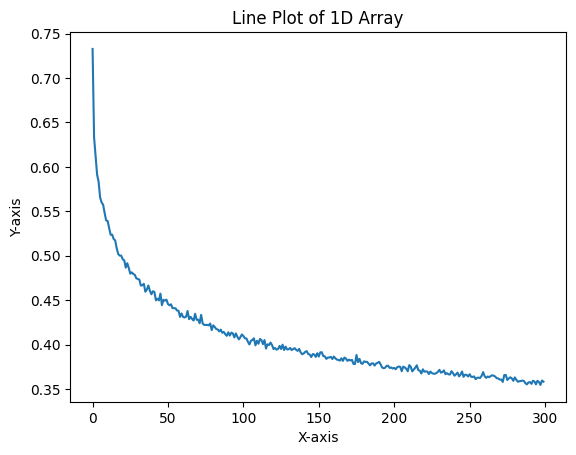

In [78]:
# TRAINING CURVE

# Plot the 1D array as a line plot
plt.plot(avg_loss)

# Add labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot of 1D Array')

# Show the plot
plt.show()

In [88]:
# SAVE THE MODEL

print("Saving model...")
experiment_name = 'saved_models'
outdir = f"exps/{experiment_name}"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model.pth")

Saving model...


**MODEL INFERENCE**

In [ ]:
# So far, the model was trained. Now the saved models can be loaded and used for testing.
# Remember to change the out_classes, depending on the loaded model

In [ ]:
# Load a model

# Select the model
pca = True
rottrans = False
full = False

if pca is True:
    out_classes = 21 # 21 for PCA, 6 for rottrans, 28 for full model

if rottrans is True:
    out_classes = 6 # 21 for PCA, 6 for rottrans, 28 for full model

if full is True:
    out_classes = 28 # 21 for PCA, 6 for rottrans, 28 for full model


# Define the model
model = ddpm_ours.MLP(
        hidden_size= hidden_size,
        hidden_layers=hidden_layers,
        emb_size= emb_size,
        time_emb= time_emb,
        input_emb= input_emb,
        in_grasp_classes = input_grasp_classes, #length one-hot vector ( now 3: cyl, plan, spher)
        out_classes = out_classes, # number of output classes (eg. 28)
        distance_emb_size = distance_emb_size # embedding size to which object matrixes are reduced
        )


# Load the model
model.load_state_dict(torch.load('./model_pca.pth'))
model.eval()


In [127]:
# Directory for grasping validation - dataset_val
main_dir = './dataset_val/'
object_dir = './dataset_val/objects/'

# Grasp code for which we want to test
grasp_code = 'core-cellphone-b35c2da756f8df5aa0eb5a85db887292'

# Load matrix distance for given object
matriz_distancias = np.load(os.path.join(object_dir+grasp_code+".npy"), allow_pickle=True)*0.11
matriz_distancias = torch.from_numpy(matriz_distancias)
matriz_distancias = matriz_distancias.reshape(1, 50, 50, 50)

# Define matrix for given object
label = torch.tensor([0, 1, 0])
label = label.reshape(1, 3)

In [ ]:
# Distance matrix for the given object
dist_repr = matriz_distancias.numpy()
plt.imshow(matriz_distancias[0,:,:,25], cmap = 'gray')

In [128]:
# Model inference
model.eval()
model.cuda()

eval_batch_size = 1
num_timesteps = 50

noise_scheduler = ddpm_ours.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, out_classes).cuda()
timesteps = list(range(num_timesteps))[::-1]

samples = []
steps = []

label = label.cuda()
matriz_distancias = matriz_distancias.cuda()

for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long().cuda()
    with torch.no_grad():
        residual = model(sample, t, label, matriz_distancias)
    
    residual = residual.cuda()
    t = t.cuda()
        
    sample = noise_scheduler.step(residual, t[0], sample)
    samples.append(sample.cpu().numpy())
    steps.append(i + 1)
    
# All diffusion steps are saved in samples
# The final generated grasp is found in samples[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

In [135]:
# Set sample to predicted test sample
sample = samples[-1][0]

# If the Rottrans model samples are to be generated
if rottrans is True:

    # Set zero to joint angles
    zeros = np.zeros(22)
    sample = np.concatenate((zeros,sample), 0)

    # Unnormalize the sample
    sample[-6:] = (sample[-6:] + 1)/2
    sample[-6:] = sample[-6:] * (mean_std_max_min[2][-6:]- mean_std_max_min[3][-6:]) + mean_std_max_min[3][-6:]

# If the PCA model samples are to be generated
if pca is True:

    # Reconstruct joint angles through PCA
    reconstructed_data = pca_encode.inverse_transform(sample[:15])

    # Concatenate with rotation and translation
    sample = np.concatenate((reconstructed_data, sample[-6:]),0)

    # Unnormalize sample
    sample = (sample + 1)/2
    sample = sample * (mean_std_max_min[2]- mean_std_max_min[3]) + mean_std_max_min[3]

# If the full model samples are to be generated
if full is True:
    sample = (sample + 1)/2
    sample = sample * (mean_std_max_min[2]- mean_std_max_min[3]) + mean_std_max_min[3]

**VISUALIZATION OF RESULT**

In [107]:
import random
from utils.hand_model_lite import HandModelMJCFLite
import numpy as np
import transforms3d
import torch
import trimesh

In [137]:
# Paths to the 3D files to be validated
mesh_path = './dataset_val/objects_3d/'
data_path = './dataset_val/grasps/'


use_visual_mesh = False
hand_file = "mjcf/shadow_hand_vis.xml" if use_visual_mesh else "mjcf/shadow_hand_wrist_free.xml"

joint_names = [
    'robot0:FFJ3', 'robot0:FFJ2', 'robot0:FFJ1', 'robot0:FFJ0',
    'robot0:MFJ3', 'robot0:MFJ2', 'robot0:MFJ1', 'robot0:MFJ0',
    'robot0:RFJ3', 'robot0:RFJ2', 'robot0:RFJ1', 'robot0:RFJ0',
    'robot0:LFJ4', 'robot0:LFJ3', 'robot0:LFJ2', 'robot0:LFJ1', 'robot0:LFJ0',
    'robot0:THJ4', 'robot0:THJ3', 'robot0:THJ2', 'robot0:THJ1', 'robot0:THJ0'
]

translation_names = ['WRJTx', 'WRJTy', 'WRJTz']
rot_names = ['WRJRx', 'WRJRy', 'WRJRz']


# Load 3D hand file
hand_model = HandModelMJCFLite(
    hand_file,
    "mjcf/meshes")


# Load grasp original code and object in 3D
# Grasp
grasp_data = np.load(
    os.path.join(data_path, grasp_code+".npy"), allow_pickle=True)

# Object
object_mesh_origin = trimesh.load(os.path.join(
    mesh_path, grasp_code, "coacd/decomposed.obj"))

In [138]:
# Select first grasph - could be any number!!
index = 0

# Substitute values in grasp for the predicted ones
qpos = grasp_data[index]['qpos']

print(qpos)

i=0
for key in qpos:
    qpos[key] = sample[i]
    i += 1

print(qpos)


# Plot the results
rot = np.array(transforms3d.euler.euler2mat(
    *[qpos[name] for name in rot_names]))
rot = rot[:, :2].T.ravel().tolist()
hand_pose = torch.tensor([qpos[name] for name in translation_names] + rot + [qpos[name]
                         for name in joint_names], dtype=torch.float, device="cpu").unsqueeze(0)
hand_model.set_parameters(hand_pose)
hand_mesh = hand_model.get_trimesh_data(0)
object_mesh = object_mesh_origin.copy().apply_scale(0.11)

(hand_mesh+object_mesh).show()

{'robot0:FFJ3': -0.15200716257095337, 'robot0:FFJ2': -0.21707293391227722, 'robot0:FFJ1': 0.7769108414649963, 'robot0:FFJ0': 0.11473862826824188, 'robot0:MFJ3': 0.03464025631546974, 'robot0:MFJ2': 0.2302238941192627, 'robot0:MFJ1': 0.5011539459228516, 'robot0:MFJ0': 0.00024240034690592438, 'robot0:RFJ3': 0.1911013424396515, 'robot0:RFJ2': 0.45050695538520813, 'robot0:RFJ1': 0.5798952579498291, 'robot0:RFJ0': 0.3004973530769348, 'robot0:LFJ4': 0.45076996088027954, 'robot0:LFJ3': 0.00580091867595911, 'robot0:LFJ2': 0.3385527431964874, 'robot0:LFJ1': 0.5138860940933228, 'robot0:LFJ0': 6.846127507742494e-05, 'robot0:THJ4': 0.3408224284648895, 'robot0:THJ3': 1.2210332155227661, 'robot0:THJ2': 0.011362502351403236, 'robot0:THJ1': -0.4851793944835663, 'robot0:THJ0': -0.03966563567519188, 'WRJRx': 0.8524779843438869, 'WRJRy': 0.7692148949326572, 'WRJRz': 1.8319443824932533, 'WRJTx': -0.1495373398065567, 'WRJTy': -0.13201336562633514, 'WRJTz': -0.04435984045267105}
{'robot0:FFJ3': -0.0093119999